In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
# default_exp analysis

# Analysis


> The analysis functions help a modeler quickly run a full time series analysis.

An analysis consists of:
1. Initializing a DGLM, using `define_dglm`.
2. Sequentially updating the model's state vector after seeing each observation in `Y`.
3. Forecasting at each time step between `forecast_start` and `forecast_end`.
4. Returning the desired output, specified in the argument `ret`. The default is to return the model and forecast samples.

The analysis starts by defining a new DGLM with `define_dglm`. The default number of observations to use is set at `prior_length=20`. Any arguments that are used to define a model in `define_dglm` can be specified as keyword arguments. Alternatively, you may define the model before using analysis, and pass the pre-initialized DGLM into analysis as the argument `model_prior`.

After the model has been initialized, the analysis loop begins. If the time step is between `forecast_start` and `forecast_end`, then the model will forecast ahead. The forecast horizon `k` must be specified. The default is to simulate `nsamps=500` times from the forecast distribution using `forecast_marginal`, from $1$ to `k` steps into the future. To simulate from the joint forecast distribution over the next `k` steps, set the flag `forecast_path=True`. Note that all forecasts are *out-of-sample*, i.e. they are made before the model has seen the observation. This is to ensure than the forecast accuracy is a fair representation of future model performance.

After the forecast has been made, the model "sees" the observation $y_t$, and updates the state vector accordingly. 

The analysis ends at `forecast_end`, or at the last observation in `Y`, whichever comes first. The output is a list specified by the argument `ret`, which may contain:
- `mod`: The final model
- `forecast`: The forecast samples
- `model_coef`: A time series of the state vector mean vector and variance matrix

Please note that `analysis` is used on a historic dataset that already exists. This means that a typical sequence of events is to run an analysis on the data you current have, and return the model. Then, you can use `mod.forecast_marginal` and `mod.forecast_path` to forecast into the future.

In [ ]:
#hide
#exporti
import numpy as np
import pandas as pd

from pybats_nbdev.define_models import define_dglm, define_dcmm, define_dbcm
from pybats_nbdev.shared import define_holiday_regressors
from collections.abc import Iterable

## Analysis for a DGLM

In [ ]:
#export
def analysis(Y, X, k, forecast_start, forecast_end,
             nsamps=500, family = 'normal', n = None,
             model_prior = None, prior_length=20, ntrend=1,
             dates = None, holidays = [],
             seasPeriods = [], seasHarmComponents = [],
             latent_factor = None, new_latent_factors = None,
             ret=['model', 'forecast'],
             mean_only = False, forecast_path = False,
             **kwargs):
    """
    This is a helpful function to run a standard analysis. The function will:
    1. Automatically initialize a DGLM
    2. Run sequential updating
    3. Forecast at each specified time step
    """

    # Add the holiday indicator variables to the regression matrix
    nhol = len(holidays)
    X = define_holiday_regressors(X, dates, holidays)

    # Check if it's a latent factor DGLM
    if latent_factor is not None:
        is_lf = True
        nlf = latent_factor.p
    else:
        is_lf = False
        nlf = 0

    if model_prior is None:
        mod = define_dglm(Y, X, family=family, n=n, prior_length=prior_length, ntrend=ntrend, nhol=nhol, nlf=nlf,
                                 seasPeriods=seasPeriods, seasHarmComponents=seasHarmComponents,
                                 **kwargs)
    else:
        mod = model_prior


    # Convert dates into row numbers
    if dates is not None:
        dates = pd.Series(dates)
        if type(forecast_start) == type(dates.iloc[0]):
            forecast_start = np.where(dates == forecast_start)[0][0]
        if type(forecast_end) == type(dates.iloc[0]):
            forecast_end = np.where(dates == forecast_end)[0][0]

    # Define the run length
    T = np.min([len(Y), forecast_end]) + 1

    if ret.__contains__('model_coef'):
        m = np.zeros([T, mod.a.shape[0]])
        C = np.zeros([T, mod.a.shape[0], mod.a.shape[0]])
        if family == 'normal':
            n = np.zeros(T)
            s = np.zeros(T)

    if new_latent_factors is not None:
        if not ret.__contains__('new_latent_factors'):
            ret.append('new_latent_factors')

        if not isinstance(new_latent_factors, Iterable):
            new_latent_factors = [new_latent_factors]

        tmp = []
        for lf in new_latent_factors:
            tmp.append(lf.copy())
        new_latent_factors = tmp

    # Create dummy variable if there are no regression covariates
    if X is None:
        X = np.array([None]*(T+k)).reshape(-1,1)
    else:
        if len(X.shape) == 1:
            X = X.reshape(-1,1)

    # Initialize updating + forecasting
    horizons = np.arange(1, k + 1)

    if mean_only:
        forecast = np.zeros([1, forecast_end - forecast_start + 1, k])
    else:
        forecast = np.zeros([nsamps, forecast_end - forecast_start + 1, k])

    for t in range(prior_length, T):

        if forecast_start <= t <= forecast_end:
            if t == forecast_start:
                print('beginning forecasting')

            if ret.__contains__('forecast'):
                if is_lf:
                    if forecast_path:
                        pm, ps, pp = latent_factor.get_lf_forecast(dates.iloc[t])
                        forecast[:, t - forecast_start, :] = mod.forecast_path_lf_copula(k=k, X=X[t + horizons - 1, :],
                                                                                         nsamps=nsamps,
                                                                                         phi_mu=pm, phi_sigma=ps, phi_psi=pp)
                    else:
                        pm, ps = latent_factor.get_lf_forecast(dates.iloc[t])
                        pp = None  # Not including path dependency in latent factor

                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x, pm, ps:
                            mod.forecast_marginal_lf_analytic(k=k, X=x, phi_mu=pm, phi_sigma=ps, nsamps=nsamps, mean_only=mean_only),
                            horizons, X[t + horizons - 1, :], pm, ps))).squeeze().T.reshape(-1, k)#.reshape(-1, 1)
                else:
                    if forecast_path:
                        forecast[:, t - forecast_start, :] = mod.forecast_path(k=k, X = X[t + horizons - 1, :], nsamps=nsamps)
                    else:
                        if family == "binomial":
                            forecast[:, t - forecast_start, :] = np.array(list(map(
                                lambda k, n, x:
                                mod.forecast_marginal(k=k, n=n, X=x, nsamps=nsamps, mean_only=mean_only),
                                horizons, n[t + horizons - 1], X[t + horizons - 1, :]))).squeeze().T.reshape(-1, k)  # .reshape(-1, 1)
                        else:
                            # Get the forecast samples for all the items over the 1:k step ahead marginal forecast distributions
                            forecast[:, t - forecast_start, :] = np.array(list(map(
                                lambda k, x:
                                mod.forecast_marginal(k=k, X=x, nsamps=nsamps, mean_only=mean_only),
                                horizons, X[t + horizons - 1, :]))).squeeze().T.reshape(-1, k)#.reshape(-1, 1)

            if ret.__contains__('new_latent_factors'):
                for lf in new_latent_factors:
                    lf.generate_lf_forecast(date=dates[t], mod=mod, X=X[t + horizons - 1],
                                            k=k, nsamps=nsamps, horizons=horizons)

        # Now observe the true y value, and update:
        if t < len(Y):
            if is_lf:
                pm, ps = latent_factor.get_lf(dates.iloc[t])
                mod.update_lf_analytic(y=Y[t], X=X[t],
                                       phi_mu=pm, phi_sigma=ps)
            else:
                if family == "binomial":
                    mod.update(y=Y[t], X=X[t], n=n[t])
                else:
                    mod.update(y=Y[t], X=X[t])

            if ret.__contains__('model_coef'):
                m[t,:] = mod.m.reshape(-1)
                C[t,:,:] = mod.C
                if family == 'normal':
                    n[t] = mod.n / mod.delVar
                    s[t] = mod.s

            if ret.__contains__('new_latent_factors'):
                for lf in new_latent_factors:
                    lf.generate_lf(date=dates[t], mod=mod, Y=Y[t], X=X[t], k=k, nsamps=nsamps)

    out = []
    for obj in ret:
        if obj == 'forecast': out.append(forecast)
        if obj == 'model': out.append(mod)
        if obj == 'model_coef':
            mod_coef = {'m':m, 'C':C}
            if family == 'normal':
                mod_coef.update({'n':n, 's':s})

            out.append(mod_coef)
        if obj == 'new_latent_factors':
            #for lf in new_latent_factors:
            #    lf.append_lf()
            #    lf.append_lf_forecast()
            if len(new_latent_factors) == 1:
                out.append(new_latent_factors[0])
            else:
                out.append(new_latent_factors)

    if len(out) == 1:
        return out[0]
    else:
        return out

This function is core to the PyBATS package, because it allows a modeler to easily run a full time series analysis in one step. Below is a quick example of analysis of quarterly inflation in the US using a normal DLM. We'll start by loading in the data:

In [ ]:
from pybats_nbdev.shared import load_us_inflation
from pybats_nbdev.analysis import analysis
import pandas as pd
from pybats_nbdev.plot import plot_data_forecast
from pybats_nbdev.point_forecast import median
import matplotlib.pyplot as plt
from pybats_nbdev.loss_functions import MAPE



data = load_us_inflation()
#data.Date = pd.DatetimeIndex(data.Date)
#data.set_index('Date')
pd.concat([data.head(3), data.tail(3)])

,Date,Inflation
0,1977-Q3,6.151037
1,1977-Q4,6.569646
2,1978-Q1,6.445443
147,2014-Q2,1.636442
148,2014-Q3,1.571666
149,2014-Q4,1.189142


And then running an analysis. We're going to use the previous (lag-1) value of inflation as a predictor.

In [ ]:
forecast_start = '1990-Q1'
forecast_end = '2013-Q4'
X = data.Inflation.values[:-1]

mod, samples = analysis(Y = data.Inflation.values[1:], X=X, family="normal",
                        k = 1, prior_length = 12,
                        forecast_start = forecast_start, forecast_end = forecast_end,
                        dates=data.Date,
                        ntrend = 2, deltrend=.99,
                        seasPeriods=[4], seasHarmComponents=[[1,2]], delseas=.99,
                        nsamps = 5000)

beginning forecasting


A couple of things to note here:
- `forecast_start` and `forecast_end` were specified by using the `dates` argument. You can also specify forecast_start and forecast_end simply by row numbers in the dataframe, and not specify any dates.

- `ntrend=2` implies that the model has an intercept and a local slope term, and `deltrend=.98` decreases the impact of older observations on the trend component by $2\%$ at each time step.

- The seasonal component was set as `seasPeriods=[4]`, because we think the seasonal effect has a cycle of length $4$ in this quarterly inflation data.

Let's examine the output. Here is the mean and variance of the state vector:

In [ ]:
mod.get_coef()

,State Vector Mean,State Vector Standard Deviation
Intercept,0.10,0.08
Local Slope,-0.00,0.00
Regn 1,0.92,0.02
Seas 1,-0.00,0.04
Seas 2,-0.00,0.04
Seas 3,0.00,0.03
Seas 4,-0.00,0.32


Finally, the lag-1 regression term is dominant, with a mean of $0.91$.

The seasonal coefficients turned out to be very small. Most likely this is because the publicly available federal reserve dataset is pre-adjusted for seasonality.

The trend terms are significant, especially the intercept with a mean of $.13$.



We can plot the forecasts using `plot_data_forecast`. We'll plot the 1-quarter ahead forecasts.

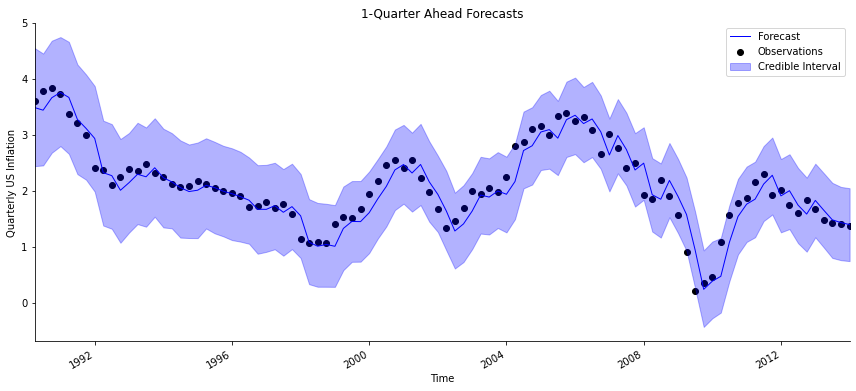

In [ ]:
forecast = median(samples)

# Plot the 1-quarter ahead forecast
h = 1
start = data[data.Date == forecast_start].index[0] + h
end = data[data.Date == forecast_end].index[0] + h + 1

fig, ax = plt.subplots(figsize=(12, 6))
plot_data_forecast(fig, ax, y = data[start:end].Inflation.values,
                   f = forecast[:,h-1],
                   samples = samples[:,:,h-1],
                   dates = pd.to_datetime(data[start:end].Date.values),
                   xlabel='Time', ylabel='Quarterly US Inflation', title='1-Quarter Ahead Forecasts')
pass

We can see that the forecasts are quite good, and nearly all of the observations fall within the $95\%$ credible interval.

There's also a clear pattern - they look 'shifted' from the data by 1 step. This is because the lag-1 predictor is very strong, with a coefficient mean of $0.92$. In effect, the model is using the previous month's value as its forecast, with some small modifications.

Finally, we can put a number on the quality of the forecast by using a loss function, the Mean Absolute Percent Error (MAPE):

In [ ]:
MAPE(data[start:end].Inflation.values, forecast[:,0]).round(1)

14.4

In [ ]:
assert(MAPE(data[start:end].Inflation.values, forecast[:,0]).round(0) == 14)

## Analysis for a DCMM

In [ ]:
#export
def analysis_dcmm(Y, X, k, forecast_start, forecast_end,
                  nsamps=500, rho=.6,
                  model_prior=None, prior_length=20, ntrend=1,
                  dates=None, holidays=[],
                  seasPeriods=[], seasHarmComponents=[], 
                  latent_factor=None, new_latent_factors=None,
                  mean_only=False,  
                  ret=['model', 'forecast'],
                   **kwargs):
    """
    This is a helpful function to run a standard analysis using a DCMM.
    """

    if latent_factor is not None:
        is_lf = True
        # Note: This assumes that the bernoulli & poisson components have the same number of latent factor components
        if isinstance(latent_factor, (list, tuple)):
            nlf = latent_factor[0].p
        else:
            nlf = latent_factor.p
    else:
        is_lf = False
        nlf = 0

    # Convert dates into row numbers
    if dates is not None:
        dates = pd.Series(dates)
        # dates = pd.to_datetime(dates, format='%y/%m/%d')
        if type(forecast_start) == type(dates.iloc[0]):
            forecast_start = np.where(dates == forecast_start)[0][0]
        if type(forecast_end) == type(dates.iloc[0]):
            forecast_end = np.where(dates == forecast_end)[0][0]

    # Add the holiday indicator variables to the regression matrix
    nhol = len(holidays)
    if nhol > 0:
        X = define_holiday_regressors(X, dates, holidays)

    # Initialize the DCMM
    if not kwargs.__contains__('model_prior'):
        mod = define_dcmm(Y, X, prior_length = prior_length, seasPeriods = seasPeriods, seasHarmComponents = seasHarmComponents,
                          nlf = nlf, rho = rho, nhol = nhol, **kwargs)
    else:
        mod = kwargs.get('model_prior')

    if ret.__contains__('new_latent_factors'):
        if not isinstance(new_latent_factors, Iterable):
            new_latent_factors = [new_latent_factors]

        tmp = []
        for sig in new_latent_factors:
            tmp.append(sig.copy())
        new_latent_factors = tmp

    # Initialize updating + forecasting
    horizons = np.arange(1,k+1)

    if mean_only:
        forecast = np.zeros([1, forecast_end - forecast_start + 1, k])
    else:
        forecast = np.zeros([nsamps, forecast_end - forecast_start + 1, k])

    T = np.min([len(Y), forecast_end]) + 1
    nu = 9

    # Run updating + forecasting
    for t in range(prior_length, T):
        # if t % 100 == 0:
        #     print(t)
        if ret.__contains__('forecast'):
            if t >= forecast_start and t <= forecast_end:
                if t == forecast_start:
                    print('beginning forecasting')

                # Get the forecast samples for all the items over the 1:k step ahead path
                if is_lf:
                    if isinstance(latent_factor, (list, tuple)):
                        pm_bern, ps_bern = latent_factor[0].get_lf_forecast(dates.iloc[t])
                        pm_pois, ps_pois = latent_factor[1].get_lf_forecast(dates.iloc[t])
                        pm = (pm_bern, pm_pois)
                        ps = (ps_bern, ps_pois)
                    else:
                        pm, ps = latent_factor.get_lf_forecast(dates.iloc[t])

                    pp = None  # Not including the path dependency of the latent factor

                    if mean_only:
                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x, pm, ps: mod.forecast_marginal_lf_analytic(
                                k=k, X=(x, x), phi_mu=(pm, pm), phi_sigma=(ps, ps), nsamps=nsamps, mean_only=mean_only),
                            horizons, X[t + horizons - 1, :], pm, ps))).reshape(1, -1)
                    else:
                        forecast[:, t - forecast_start, :] = mod.forecast_path_lf_copula(
                        k=k, X=(X[t + horizons - 1, :], X[t + horizons - 1, :]),
                        phi_mu=(pm, pm), phi_sigma=(ps, ps), phi_psi=(pp, pp), nsamps=nsamps, t_dist=True, nu=nu)
                else:
                    if mean_only:
                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x: mod.forecast_marginal(
                                k=k, X=(x, x), nsamps=nsamps, mean_only=mean_only),
                            horizons, X[t + horizons - 1, :]))).reshape(1,-1)
                    else:
                        forecast[:, t - forecast_start, :] = mod.forecast_path_copula(
                        k=k, X=(X[t + horizons - 1, :], X[t + horizons - 1, :]), nsamps=nsamps, t_dist=True, nu=nu)

        if ret.__contains__('new_latent_factors'):
            if t >= forecast_start and t <= forecast_end:
                for lf in new_latent_factors:
                    lf.generate_lf_forecast(date=dates.iloc[t], mod=mod, X=X[t + horizons - 1, :],
                                                k=k, nsamps=nsamps, horizons=horizons)

        # Update the DCMM
        if is_lf:
            if isinstance(latent_factor, (list, tuple)):
                pm_bern, ps_bern = latent_factor[0].get_lf(dates.iloc[t])
                pm_pois, ps_pois = latent_factor[1].get_lf(dates.iloc[t])
                pm = (pm_bern, pm_pois)
                ps = (ps_bern, ps_pois)
            else:
                pm, ps = latent_factor.get_lf(dates.iloc[t])

            mod.update_lf_analytic(y=Y[t], X=(X[t], X[t]),
                                   phi_mu=(pm, pm), phi_sigma=(ps, ps))
        else:
            mod.update(y = Y[t], X=(X[t], X[t]))

        if ret.__contains__('new_latent_factors'):
            for lf in new_latent_factors:
                lf.generate_lf(date=dates.iloc[t], mod=mod, X=X[t + horizons - 1, :],
                                   k=k, nsamps=nsamps, horizons=horizons)

    out = []
    for obj in ret:
        if obj == 'forecast': out.append(forecast)
        if obj == 'model': out.append(mod)
        if obj == 'new_latent_factors':
            #for lf in new_latent_factors:
            #    lf.append_lf()
            #    lf.append_lf_forecast()
            if len(new_latent_factors) == 1:
                out.append(new_latent_factors[0])
            else:
                out.append(new_latent_factors)

    if len(out) == 1:
        return out[0]
    else:
        return out

This function works identically to the standard `analysis`, but is specialized for a DCMM.

The observations must be integer counts, which can be modeled as a combination of a Poisson and Bernoulli DGLM. Typically a DCMM is equally good as a Poisson DGLM for modeling large integers, but significantly better for series of smaller integers with many zeros.

Note that by default, all simulated forecasts made with `analysis_dcmm` are *path* forecasts, meaning that they account for the dependence across forecast horizons.

## Analysis for a DBCM

In [ ]:
#export
def analysis_dbcm(Y_transaction, X_transaction, Y_cascade, X_cascade, excess,
                  k, forecast_start, forecast_end, nsamps = 500, rho = .6,
                  model_prior=None, prior_length=20, ntrend=1,
                  dates=None, holidays = [],
                  latent_factor = None, new_latent_factors = None,
                  seasPeriods = [], seasHarmComponents = [],
                  mean_only=False,        
                  ret=['model', 'forecast'],
                   **kwargs):
    """
    This is a helpful function to run a standard analysis using a DBCM.
    """

    if latent_factor is not None:
        is_lf = True
        # Note: This assumes that the bernoulli & poisson components have the same number of latent factor components
        if isinstance(latent_factor, (list, tuple)):
            nlf = latent_factor[0].p
        else:
            nlf = latent_factor.p
    else:
        is_lf = False
        nlf = 0

    # Convert dates into row numbers
    if dates is not None:
        dates = pd.Series(dates)
        # dates = pd.to_datetime(dates, format='%y/%m/%d')
        if type(forecast_start) == type(dates.iloc[0]):
            forecast_start = np.where(dates == forecast_start)[0][0]
        if type(forecast_end) == type(dates.iloc[0]):
            forecast_end = np.where(dates == forecast_end)[0][0]

    # Add the holiday indicator variables to the regression matrix
    nhol = len(holidays)
    if nhol > 0:
        X_transaction = define_holiday_regressors(X_transaction, dates, holidays)


    if not kwargs.__contains__('model_prior'):
        mod = define_dbcm(Y_transaction, X_transaction, Y_cascade, X_cascade,
                          excess_values = excess, prior_length = prior_length,
                          seasPeriods = seasPeriods, seasHarmComponents=seasHarmComponents,
                          nlf = nlf, rho = rho, nhol=nhol, **kwargs)
    else:
        mod = kwargs.get('model_prior')

    if ret.__contains__('new_latent_factors'):
        if not isinstance(new_latent_factors, Iterable):
            new_latent_factors = [new_latent_factors]

        tmp = []
        for sig in new_latent_factors:
            tmp.append(sig.copy())
        new_latent_factors = tmp

    # Initialize updating + forecasting
    horizons = np.arange(1,k+1)

    if mean_only:
        forecast = np.zeros([1, forecast_end - forecast_start + 1, k])
    else:
        forecast = np.zeros([nsamps, forecast_end - forecast_start + 1, k])

    T = np.min([len(Y_transaction)- k, forecast_end]) + 1
    nu = 9

    # Run updating + forecasting
    for t in range(prior_length, T):
        # if t % 100 == 0:
        #     print(t)
            # print(mod.dcmm.pois_mod.param1)
            # print(mod.dcmm.pois_mod.param2)
        if ret.__contains__('forecast'):
            if t >= forecast_start and t <= forecast_end:
                if t == forecast_start:
                    print('beginning forecasting')

                # Get the forecast samples for all the items over the 1:k step ahead path
                if is_lf:
                    if isinstance(latent_factor, (list, tuple)):
                        pm_bern, ps_bern = latent_factor[0].get_lf_forecast(dates.iloc[t])
                        pm_pois, ps_pois = latent_factor[1].get_lf_forecast(dates.iloc[t])
                        pm = (pm_bern, pm_pois)
                        ps = (ps_bern, ps_pois)
                        pp = None  # Not including path dependency in latent factor
                    else:
                        if latent_factor.forecast_path:
                            pm, ps, pp = latent_factor.get_lf_forecast(dates.iloc[t])
                        else:
                            pm, ps = latent_factor.get_lf_forecast(dates.iloc[t])
                            pp = None

                    if mean_only:
                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x_trans, x_cascade, pm, ps: mod.forecast_marginal_lf_analytic(
                                k=k, X_transaction=x_trans, X_cascade=x_cascade,
                                phi_mu=pm, phi_sigma=ps, nsamps=nsamps, mean_only=mean_only),
                            horizons, X_transaction[t + horizons - 1, :], X_cascade[t + horizons - 1, :], pm, ps))).reshape(1, -1)
                    else:
                        forecast[:, t - forecast_start, :] = mod.forecast_path_lf_copula(
                            k=k, X_transaction=X_transaction[t + horizons - 1, :], X_cascade=X_cascade[t + horizons - 1, :],
                            phi_mu=pm, phi_sigma=ps, phi_psi=pp, nsamps=nsamps, t_dist=True, nu=nu)
                else:
                    if mean_only:
                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x_trans, x_cascade: mod.forecast_marginal(
                                k=k, X_transaction=x_trans, X_cascade=x_cascade, nsamps=nsamps, mean_only=mean_only),
                            horizons, X_transaction[t + horizons - 1, :], X_cascade[t + horizons - 1, :]))).reshape(1,-1)
                    else:
                        forecast[:, t - forecast_start, :] = mod.forecast_path_copula(
                            k=k, X_transaction=X_transaction[t + horizons - 1, :], X_cascade=X_cascade[t + horizons - 1, :],
                            nsamps=nsamps, t_dist=True, nu=nu)

        if ret.__contains__('new_latent_factors'):
            if t >= forecast_start and t <= forecast_end:
                for lf in new_latent_factors:
                    lf.generate_lf_forecast(date=dates.iloc[t], mod=mod, X_transaction=X_transaction[t + horizons - 1, :],
                                                X_cascade = X_cascade[t + horizons - 1, :],
                                                k=k, nsamps=nsamps, horizons=horizons)
        # Update the DBCM
        if is_lf:
            if isinstance(latent_factor, (list, tuple)):
                pm_bern, ps_bern = latent_factor[0].get_lf(dates.iloc[t])
                pm_pois, ps_pois = latent_factor[1].get_lf(dates.iloc[t])
                pm = (pm_bern, pm_pois)
                ps = (ps_bern, ps_pois)
            else:
                pm, ps = latent_factor.get_lf(dates.iloc[t])

            mod.update_lf_analytic(y_transaction=Y_transaction[t], X_transaction=X_transaction[t, :],
                                   y_cascade=Y_cascade[t,:], X_cascade=X_cascade[t, :],
                                   phi_mu=pm, phi_sigma=ps, excess=excess[t])
        else:
            mod.update(y_transaction=Y_transaction[t], X_transaction=X_transaction[t, :],
                       y_cascade=Y_cascade[t,:], X_cascade=X_cascade[t, :], excess=excess[t])

        if ret.__contains__('new_latent_factors'):
            for lf in new_latent_factors:
                lf.generate_lf(date=dates.iloc[t], mod=mod, X_transaction=X_transaction[t + horizons - 1, :],
                                   X_cascade = X_cascade[t + horizons - 1, :],
                                   k=k, nsamps=nsamps, horizons=horizons)

    out = []
    for obj in ret:
        if obj == 'forecast': out.append(forecast)
        if obj == 'model': out.append(mod)
        if obj == 'new_latent_factors':
            #for lf in new_latent_factors:
            #    lf.append_lf()
            #    lf.append_lf_forecast()
            if len(new_latent_factors) == 1:
                out.append(new_latent_factors[0])
            else:
                out.append(new_latent_factors)

    if len(out) == 1:
        return out[0]
    else:
        return out

This function works identically to the standard `analysis`, but is specialized for a DBCM.

Separate data must be specified for the DCMM on transactions, `y_transaction` and `X_transaction`, the binomial cascade,`y_cascade`, `X_cascade`, and any excess counts, `excess`.

Note that by default, all simulated forecasts made with `analysis_dbcm` are *path* forecasts, meaning that they account for the dependence across forecast horizons.

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_dglm.ipynb.
Converted 01_update.ipynb.
Converted 02_forecast.ipynb.
Converted 03_define_models.ipynb.
Converted 04_seasonal.ipynb.
Converted 05_analysis.ipynb.
Converted 06_conjugates.ipynb.
Converted 07_point_forecast.ipynb.
Converted 08_loss_functions.ipynb.
Converted 09_plot.ipynb.
Converted 10_shared.ipynb.
Converted 11_dcmm.ipynb.
Converted 12_dbcm.ipynb.
Converted 13_latent_factor.ipynb.
Converted 14_latent_factor_fxns.ipynb.
Converted index.ipynb.
